In [53]:
just_checking_integrity=True

In [54]:
import gc
import pandas as pd
import scipy.sparse as sps

In [55]:
valid=sps.load_npz("../dataset/processed_data/URM_valid_bought.npz")
bought=valid.indices

In [56]:
dataset=None
dataset_max=None
#["UCF","ICBF","ICF","Graph","TopPop100","TopPop50","TopPop15"]
for file in ["UCF","ICBF","Graph","ICF"]:
    print(gc.collect())
    print(f"loading {file}")
    df=pd.read_csv(f"../dataset/candidates/traditional_recs/train/{file}.csv")
    print(len(df))
    print(f"loaded {file}")
    for col in df:
        if "Max" in col:
            df_max=df[["Session_Id",col]].drop_duplicates()
        elif "Score" in col:
            df_feats=df[["Session_Id","Item_ID",col]]
    if dataset is None:
        dataset=df_feats
        dataset_max=df_max
    else:
        dataset=dataset.merge(df_feats,on=["Session_Id","Item_ID"],how="outer")
        dataset_max=dataset_max.merge(df_max,on=["Session_Id"],how="outer")
    del df
        

#del dataset_max
del df_feats
del df_max

1223
loading UCF
2560109
loaded UCF
0
loading ICBF
2315601
loaded ICBF
0
loading Graph
1349832
loaded Graph
0
loading ICF
2832490
loaded ICF


In [57]:
import ast
submission_df=pd.read_csv("../dataset/candidates/NN/GRU/train/candidates.csv")
if just_checking_integrity:
    submission_df["score"]=submission_df["score"].apply(lambda x:x.replace("-inf","0"))
    submission_df["score"]=submission_df["score"].map(ast.literal_eval)
else:
    submission_df["score"]=submission_df["score"].map(ast.literal_eval)
submission_df["code"]=submission_df["code"].map(ast.literal_eval)
submission_df["rank"]=submission_df["rank"].map(ast.literal_eval)
submission_df = submission_df.explode(['code','score', 'rank'])
submission_df[["session_id","code","rank"]]=submission_df[["session_id","code","rank"]].astype(int)
submission_df.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_gru","score":"score_gru"},inplace=True)

In [58]:
submission_df.head()

,Session_Id,Item_ID,score_gru,rank_gru
0,918743,554,0.000107,1
0,918743,2276,0.000101,2
0,918743,2694,0.0001,3
0,918743,1609,0.000092,4
0,918743,3879,0.000083,5


In [59]:
import ast
submission_df_tr=pd.read_csv("../dataset/candidates/NN/Transformer/train/candidates.csv")
if just_checking_integrity:
    submission_df_tr["score"]=submission_df_tr["score"].apply(lambda x:x.replace("-inf","0"))
    submission_df_tr["score"]=submission_df_tr["score"].map(ast.literal_eval)
else:
    submission_df_tr["score"]=submission_df_tr["score"].map(ast.literal_eval)
submission_df_tr["code"]=submission_df_tr["code"].map(ast.literal_eval)
submission_df_tr["rank"]=submission_df_tr["rank"].map(ast.literal_eval)
submission_df_tr = submission_df_tr.explode(['code','score', 'rank'])
submission_df_tr[["session_id","code","rank"]]=submission_df_tr[["session_id","code","rank"]].astype(int)
submission_df_tr.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_transformer","score":"score_transformer"},inplace=True)

In [60]:
import ast
submission_df_LSTM=pd.read_csv("../dataset/candidates/NN/LSTM/train/candidates.csv")
if just_checking_integrity:
    submission_df_LSTM["score"]=submission_df_LSTM["score"].apply(lambda x:x.replace("-inf","0"))
    submission_df_LSTM["score"]=submission_df_LSTM["score"].map(ast.literal_eval)
else:
    submission_df_LSTM["score"]=submission_df_LSTM["score"].map(ast.literal_eval)
submission_df_LSTM["code"]=submission_df_LSTM["code"].map(ast.literal_eval)
submission_df_LSTM["rank"]=submission_df_LSTM["rank"].map(ast.literal_eval)
submission_df_LSTM = submission_df_LSTM.explode(['code','score', 'rank'])
submission_df_LSTM[["session_id","code","rank"]]=submission_df_LSTM[["session_id","code","rank"]].astype(int)
submission_df_LSTM.rename(columns={"code":"Item_ID","session_id":"Session_Id","rank":"rank_LSTM","score":"score_LSTM"},inplace=True)

In [61]:
dataset=dataset.merge(submission_df,on=["Session_Id","Item_ID"],how="outer")
dataset=dataset.merge(submission_df_tr,on=["Session_Id","Item_ID"],how="outer")
dataset=dataset.merge(submission_df_LSTM,on=["Session_Id","Item_ID"],how="outer")

dataset=dataset.merge(dataset_max,on=["Session_Id"],how="left")


In [62]:
if just_checking_integrity:
    dataset=dataset[:int(0.5*len(dataset))]

In [63]:
del dataset_max
del submission_df
del submission_df_tr

In [64]:
import numpy as np
sessions=np.unique(dataset["Session_Id"])
train=pd.DataFrame()
train["Session_Id"]=sessions
if just_checking_integrity:
    train["Item_ID"]=bought[:len(sessions)]
else:
    train["Item_ID"]=bought
train["target"]=1

In [65]:
gc.collect()

200

In [66]:
dataset=dataset.merge(train,on=["Session_Id","Item_ID"],how="left")
dataset.fillna(0,inplace=True)
gc.collect()

23

In [67]:
dataset["target"]=dataset["target"].astype("int8")
gc.collect()

23

In [68]:
sessions_containing_bought_among_candidates=dataset[["Session_Id","target"]].groupby("Session_Id").agg(sum).reset_index()
sessions_containing_bought_among_candidates=sessions_containing_bought_among_candidates.loc[sessions_containing_bought_among_candidates["target"]>0]

dataset=dataset[dataset['Session_Id'].isin(sessions_containing_bought_among_candidates["Session_Id"].tolist())]

In [69]:
dataset.head(20)

,Session_Id,Item_ID,Score_UCF,Score_ICBF,Score_Graph,Score_ICF,score_gru,rank_gru,score_transformer,rank_transformer,score_LSTM,rank_LSTM,Max_Score_UCF,Max_Score_ICBF,Max_Score_Graph,Max_Score_ICF,target
210,68383,1,0.028674,0.000000,0.000000,0.000000,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
211,68383,55,0.048412,0.632362,0.010966,0.021035,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
212,68383,115,0.027344,0.000000,0.005310,0.011567,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
213,68383,189,0.214174,0.190140,0.099715,0.522071,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
214,68383,201,0.027889,0.000000,0.000000,0.000000,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
215,68383,215,0.051406,0.000000,0.007412,0.010804,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
216,68383,260,0.037503,0.000000,0.006071,0.011254,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
217,68383,313,0.021405,0.000000,0.000000,0.000000,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
218,68383,320,0.045035,0.000000,0.007180,0.012450,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
219,68383,357,0.035766,0.000000,0.005443,0.000000,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0


In [70]:
dataset

,Session_Id,Item_ID,Score_UCF,Score_ICBF,Score_Graph,Score_ICF,score_gru,rank_gru,score_transformer,rank_transformer,score_LSTM,rank_LSTM,Max_Score_UCF,Max_Score_ICBF,Max_Score_Graph,Max_Score_ICF,target
210,68383,1,0.028674,0.000000,0.000000,0.000000,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
211,68383,55,0.048412,0.632362,0.010966,0.021035,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
212,68383,115,0.027344,0.000000,0.005310,0.011567,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
213,68383,189,0.214174,0.190140,0.099715,0.522071,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
214,68383,201,0.027889,0.000000,0.000000,0.000000,0,0.0,0,0.0,0,0.0,407.55798,7.204127,35.312874,1.031505,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461684,70461,2107,0.229372,0.701958,0.085133,0.668412,0,0.0,0,0.0,0,0.0,124.45465,6.449228,5.333655,0.502462,0
461685,70461,2121,0.082302,0.000000,0.000000,0.000000,0,0.0,0,0.0,0,0.0,124.45465,6.449228,5.333655,0.502462,0
461686,70461,2244,0.072352,0.000000,0.000000,0.000000,0,0.0,0,0.0,0,0.0,124.45465,6.449228,5.333655,0.502462,0
461687,70461,2257,0.089634,0.000000,0.000000,0.000000,0,0.0,0,0.0,0,0.0,124.45465,6.449228,5.333655,0.502462,0


In [71]:
dataset_macro_features = pd.read_csv('../dataset/processed_data/macro_feats_NN.csv',
                                     usecols=['session_id',
                                                'session_similarity',
                                                'session_similarity_uniques', 'session_similarity_feats', 'session_similarity_feats_uniques',
                                              'length_of_session_seconds',
                   'avg_time_spent_per_item_seconds',
                   'variance_time_spent_per_item_seconds',
                   'n_seen_items',
                   'n_unique_items',])

dataset_macro_features.rename(columns={'session_id':'Session_Id'}, inplace=True)
dataset = dataset.merge(dataset_macro_features, on='Session_Id', how='left')
del dataset_macro_features

In [72]:
#dataset.drop('Max_Score_TopPop15', axis=1, inplace=True)

In [73]:
from sklearn.model_selection import KFold
import lightgbm
import os
k=10
try:
    os.mkdir(f"./{k}_fold_ranker_NN_transformer_LSTM_with_features_toppop_15_no_max")
except:
    pass

score=0
kf = KFold(n_splits=k)
index=0
for train_index, valid_index in kf.split(train):

    train_sessions=train["Session_Id"][train_index].tolist()
    valid_sessions=train["Session_Id"][valid_index].tolist()

    train_set=dataset[dataset["Session_Id"].isin(train_sessions)]
    valid_set=dataset[dataset["Session_Id"].isin(valid_sessions)]

    train_set=train_set.sort_values("Session_Id")
    valid_set=valid_set.sort_values("Session_Id")
    
    qids_train = train_set[["Session_Id"]].groupby("Session_Id")["Session_Id"].count().to_numpy()
    qids_valid = valid_set[["Session_Id"]].groupby("Session_Id")["Session_Id"].count().to_numpy()
    
    X_train=train_set.drop(["target","Session_Id","Item_ID"],axis=1)
    y_train=train_set["target"]
    
    X_valid=valid_set.drop(["target","Session_Id","Item_ID"],axis=1)
    y_valid=valid_set["target"]

    model = lightgbm.LGBMRanker(
    objective="lambdarank",
    #objective="rank_xendcg",
    #metric="mrr",
    n_estimators=2000,
    lambdarank_truncation_level=103,
    reg_alpha=1e-4,
    learning_rate=0.05,
    min_child_samples=400,
    subsample=0.8,
    subsample_freq=20
    )
    ranker=model.fit(
        X=X_train,
        y=y_train,
        group=qids_train,
        eval_set=[(X_valid, y_valid)],
        eval_group=[qids_valid],
        eval_at=(100),
        callbacks=[lightgbm.log_evaluation(),lightgbm.early_stopping(20,first_metric_only=True)],
        #verbose=10,
        eval_metric=["map","ndcg"]
    )
    ranker.booster_.save_model(f'../rankers/model_{index}.txt')
    #Get maximum val score
    score+=np.max(ranker._evals_result["valid_0"]["map@100"])
    index+=1

[1]	valid_0's map@100: 0.205031	valid_0's ndcg@100: 0.3401
Training until validation scores don't improve for 20 rounds
[2]	valid_0's map@100: 0.220224	valid_0's ndcg@100: 0.356396
[3]	valid_0's map@100: 0.243241	valid_0's ndcg@100: 0.37398
[4]	valid_0's map@100: 0.239841	valid_0's ndcg@100: 0.373279
[5]	valid_0's map@100: 0.237266	valid_0's ndcg@100: 0.369288
[6]	valid_0's map@100: 0.230445	valid_0's ndcg@100: 0.36512
[7]	valid_0's map@100: 0.233693	valid_0's ndcg@100: 0.367776
[8]	valid_0's map@100: 0.225184	valid_0's ndcg@100: 0.359315
[9]	valid_0's map@100: 0.229732	valid_0's ndcg@100: 0.36187
[10]	valid_0's map@100: 0.230066	valid_0's ndcg@100: 0.361353
[11]	valid_0's map@100: 0.230242	valid_0's ndcg@100: 0.361408
[12]	valid_0's map@100: 0.229977	valid_0's ndcg@100: 0.361006
[13]	valid_0's map@100: 0.231712	valid_0's ndcg@100: 0.363327
[14]	valid_0's map@100: 0.232126	valid_0's ndcg@100: 0.362575
[15]	valid_0's map@100: 0.240759	valid_0's ndcg@100: 0.368963
[16]	valid_0's map@100:

In [74]:
final_performcance=score/k
print("overall MAP@100 = ", final_performcance)

overall MAP@100 =  0.2730437307930526


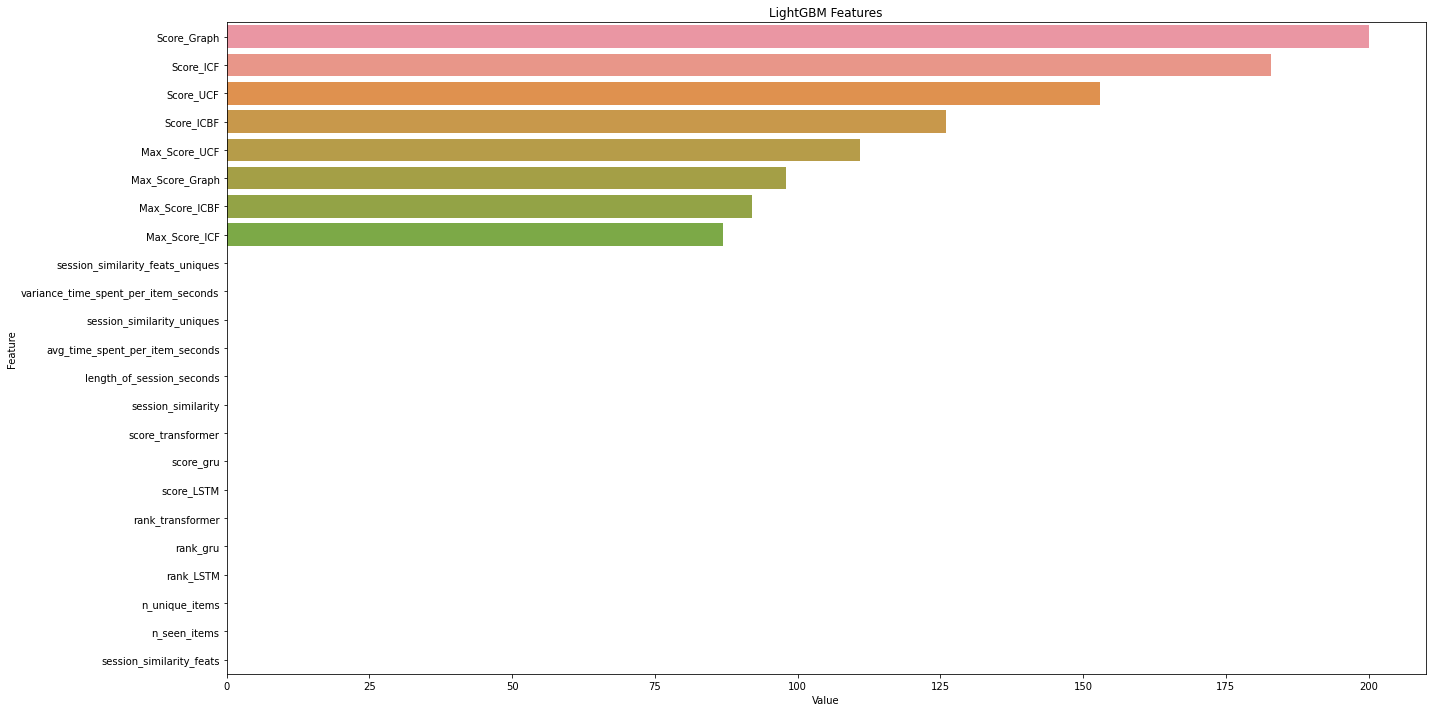

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(ranker.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')